**Library**

In [1]:
!pip install emoji
!pip install Sastrawi
!pip install umap-learn
!pip install simplemma
!pip install fasttext

In [2]:
import string
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import umap
import simplemma
import fasttext
from collections import Counter
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
sns.set(style='white', palette='muted', color_codes=True)

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Pre-Processing

In [3]:
df = pd.read_csv('/content/Scrapping-PUBGM.csv')
df.head()

content  score    Label
0  tolong dong... ko kalo log in pake jaringan wi...      2  Negatif
1  PUBG MOBILE sekarang sudah sepi, masuk match m...      2  Negatif
2              Server selalu bermasalah ketika login      1  Negatif
3  Games terlalu berat, sering mati hp pas nembak...      1  Negatif
4  Gyroscope pas diarahin ke bawan pelan malah na...      1  Negatif

**Case Folding**

In [4]:
def casefolding(content):
  content = content.lower()
  return content

df['content'] = df['content'].apply(lambda x: casefolding(x))

**Cleaning**

In [5]:
def cleaning(content):
  content = content.strip(' ')
  content = re.sub(r'\d+', '', content)
  content = content.translate(str.maketrans('','', string.punctuation))
  content = re.sub(r'\b[a-zA-Z]\b', '', content)
  content = re.sub(r'\s+', ' ', content)
  return content

df['content'] = df['content'].apply(lambda x: cleaning(x))

**Emoji/Emoticon Removal**

In [6]:
def emoji_removal(content):
  content = emoji.replace_emoji(content, replace='')
  return content

df['content'] = df['content'].apply(lambda x: emoji_removal(x))

In [7]:
def remove_emoticons(content):
    emoticon_pattern = re.compile(r"""
        (?::|;|=) # Kolom, titik koma, atau tanda sama dengan untuk wajah
        (?:-)? # Tanda minus opsional
        (?:\)|\(|D|P|O|/|\|S) # char yang menunjukkan ekspresi
        """, re.VERBOSE)

    return emoticon_pattern.sub(r'', content)

df['content'] = df['content'].apply(lambda x: remove_emoticons(x))

**Spell Checker (Spelling Correction, Slang Words, Chat Words)**

In [8]:
spellchecker_dict = pd.read_csv('/content/spellcheck_dict_pubgm.csv')
spellchecker_dict.dropna(subset=['replacement'], inplace=True)
spellchecker_dict = dict(zip(spellchecker_dict['term'], spellchecker_dict['replacement']))

def spellcheck_text(text, spellchecker_dict):
    words = text.split()
    corrected_words = [spellchecker_dict.get(word, word) for word in words]
    return ' '.join(corrected_words)

df['content'] = df['content'].apply(lambda x: spellcheck_text(x, spellchecker_dict))

**Tokenization**

In [9]:
def tokenisasi(content):
  content = word_tokenize(content)
  return content

df['textToken'] = df['content'].apply(lambda x: tokenisasi(x))

In [10]:
df.head()

content  score    Label  \
0  tolong dong kok kalau log in pakai jaringan wi...      2  Negatif   
1  pubg mobile sekarang sudah sepi masuk match ma...      2  Negatif   
2              server selalu bermasalah ketika login      1  Negatif   
3  game terlalu berat sering mati hp pas nembak m...      1  Negatif   
4  gyroscope pas arah ke bawa pelan malah naik se...      1  Negatif   

                                           textToken  
0  [tolong, dong, kok, kalau, log, in, pakai, jar...  
1  [pubg, mobile, sekarang, sudah, sepi, masuk, m...  
2        [server, selalu, bermasalah, ketika, login]  
3  [game, terlalu, berat, sering, mati, hp, pas, ...  
4  [gyroscope, pas, arah, ke, bawa, pelan, malah,...

**Lemmatization**

In [11]:
def lemmatisasi(content):
  return [simplemma.lemmatize(word, lang='id') for word in content]

df['textLemma'] = df['textToken'].apply(lambda x: lemmatisasi(x))

**Stopwords Removal**

In [12]:
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()

nltk_stopword = stopwords.words('indonesian')

combine_stopwords = set(sastrawi_stopwords + nltk_stopword)

def stopwords(content):
  content = [word for word in content if word not in combine_stopwords]
  return content

df['textSWR'] = df['textLemma'].apply(lambda x: stopwords(x))

**Stemming**

In [13]:
!pip install Sastrawi

In [14]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [15]:
def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}
hitung = 0

for document in df['textSWR']:
  for term in document:
    if term not in term_dict:
      term_dict[term] = ' '

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)
  hitung += 1

def get_stemmed_term(document):
  return [term_dict[term] for term in document]

df['textStemm'] = df['textSWR'].apply(lambda x: get_stemmed_term(x))

**Stopwords Removal Extended (After WordCloud)**

In [16]:
cswr = set(STOPWORDS)
cswr.update(["game", "nya", "main", "hero", "match",
             "tim", "aja", "sistem", "banget", "udah",
             "kasih", "player", "update", "pas", "rank",
             "event", "hp"])

def remove_cswr(word_list):
    return [word for word in word_list if word.lower() not in cswr]

df['textStemm'] = df['textStemm'].apply(remove_cswr)

In [17]:
cswr_positif = set(STOPWORDS)
cswr_positif.update(["lag", "nya bagus", "bug"])

cswr_negatif = set(STOPWORDS)
cswr_negatif.update(["bagus", "baik", "suka"])

def remove_cswr(word_list, label):

    if label == 'Positif':
        custom_stopwords = cswr_positif
    elif label == 'Negatif':
        custom_stopwords = cswr_negatif

    return [word for word in word_list if word.lower() not in custom_stopwords]

df['textStemm'] = df.apply(lambda row: remove_cswr(row['textStemm'], row['Label']), axis=1)

In [18]:
df['textStemmSTR'] = df['textStemm'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [19]:
df.head()

content  score    Label  \
0  tolong dong kok kalau log in pakai jaringan wi...      2  Negatif   
1  pubg mobile sekarang sudah sepi masuk match ma...      2  Negatif   
2              server selalu bermasalah ketika login      1  Negatif   
3  game terlalu berat sering mati hp pas nembak m...      1  Negatif   
4  gyroscope pas arah ke bawa pelan malah naik se...      1  Negatif   

                                           textToken  \
0  [tolong, dong, kok, kalau, log, in, pakai, jar...   
1  [pubg, mobile, sekarang, sudah, sepi, masuk, m...   
2        [server, selalu, bermasalah, ketika, login]   
3  [game, terlalu, berat, sering, mati, hp, pas, ...   
4  [gyroscope, pas, arah, ke, bawa, pelan, malah,...   

                                           textLemma  \
0  [tolong, dong, kok, kalau, log, in, pakai, jar...   
1  [pubg, mobile, sekarang, sudah, sepi, masuk, m...   
2           [server, selalu, masalah, ketika, login]   
3  [game, terlalu, berat, sering, mati, hp, pas, ...   
4  [gyroscope, pas, arah, ke, bawa, pelan, malah,...   

                                             textSWR  \
0  [log, in, pakai, jaring, wifi, masuk, aplikasi...   
1  [pubg, mobile, sepi, masuk, match, making, nun...   
2                                    [server, login]   
3  [game, berat, mati, hp, pas, nembak, maaf, bin...   
4  [gyroscope, pas, arah, bawa, pelan, arah, pela...   

                                           textStemm  \
0  [log, pakai, jaring, wifi, masuk, aplikasi, la...   
1  [pubg, mobile, sepi, masuk, making, nunggu, me...   
2                                    [server, login]   
3       [berat, mati, nembak, maaf, bintang, kecewa]   
4  [gyroscope, arah, bawa, pelan, arah, pelan, tu...   

                                        textStemmSTR  
0        log pakai jaring wifi masuk aplikasi lancar  
1  pubg mobile sepi masuk making nunggu menit mas...  
2                                       server login  
3              berat mati nembak maaf bintang kecewa  
4  gyroscope arah bawa pelan arah pelan turun atu...

# Feature Engineering

## TF-IDF

In [20]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=1500)

response = tfidf.fit_transform(df['textStemmSTR'])

data_IDF = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names_out())

In [21]:
df['Label'] = df['Label'].replace({'Negatif': 0, 'Positif': 1})

## BOW

In [22]:
bowvec = CountVectorizer()

response = bowvec.fit_transform(df['textStemmSTR'])

data_BOW = pd.DataFrame(response.toarray(), columns=bowvec.get_feature_names_out())

## w2vec

In [23]:
w2vec = Word2Vec(
    sentences=df['textStemm'],
    vector_size=100,
    window=5,
    min_count=3,
    sg=0
)

w2vec.save('word2vec.model')

In [24]:
model_w2vec = Word2Vec.load('word2vec.model')

In [25]:
w2v = model_w2vec.wv
w2v.index_to_key[:10]

['pubg',
 'bug',
 'frame',
 'musuh',
 'bagus',
 'masuk',
 'jaring',
 'fps',
 'parah',
 'login']

In [26]:
X = umap.UMAP().fit_transform(w2v.vectors)

df2 = pd.DataFrame(X, columns=['umap1', 'umap2'])
df2['word'] = w2v.index_to_key

fig = px.scatter(df2, x='umap1', y='umap2', text='word')
fig.update_traces(textposition='top center')
fig.update_layout(height = 800,
                  title_text = 'Word2Vec Visualization')
fig.show()

## FastText

In [27]:
data_FT = df['textStemmSTR']

In [28]:
data_FT

0             log pakai jaring wifi masuk aplikasi lancar
1       pubg mobile sepi masuk making nunggu menit mas...
2                                            server login
3                   berat mati nembak maaf bintang kecewa
4       gyroscope arah bawa pelan arah pelan turun atu...
                              ...                        
1724    grafik kontrol bagus min masuk pulau delay lob...
1725    many cheat rate bintang cheater bersih pubg ve...
1726    miramarnya pisah hilang saran download miramar...
1727    sanhok note aman aman fps drop fps versi bug s...
1728    upgrade upgrade maen tinggal orang tau tau con...
Name: textStemmSTR, Length: 1729, dtype: object

In [29]:
data_FT.to_csv('data_FT.txt', index=False, header=False, sep=' ')

In [30]:
model_FT = '/content/data_FT.txt'

In [31]:
model = fasttext.train_supervised(model_FT, epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)
model.save_model("fasttext_model.bin")

print("Fasttext Model trained and saved successfully!")

Fasttext Model trained and saved successfully!


In [32]:
words = list(model.words)
word_vectors = np.array([model.get_word_vector(word) for word in words])

FastText (PCA)

In [33]:
pca = PCA(n_components=2)

word_vector_2d = pca.fit_transform(word_vectors)

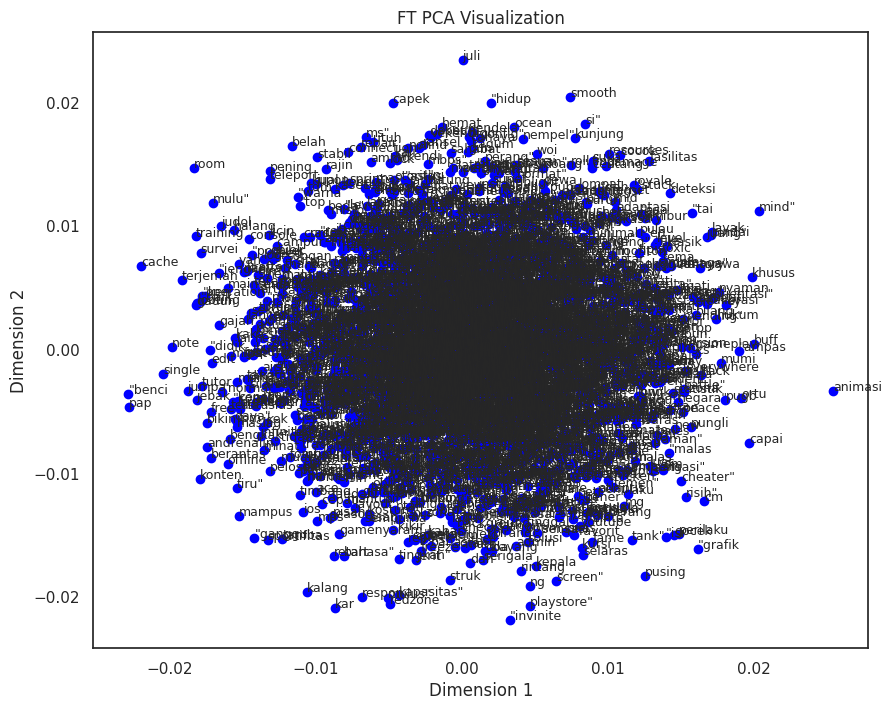

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(word_vector_2d[:, 0], word_vector_2d[:, 1], c='blue', label='Words')

for i, word in enumerate(words):
  plt.annotate(word, (word_vector_2d[i, 0], word_vector_2d[i, 1]), fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('FT PCA Visualization')
plt.show()

FastText (PCA) with KNN

In [35]:
n_neighbors = 1

nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(word_vector_2d)
distances, indices = nearest_neighbors.kneighbors(word_vector_2d)

subset_size = 100
words_subset = words[:subset_size]
word_vector_subset = word_vector_2d[:subset_size]

fig = px.scatter(x=word_vector_subset[:, 0], y=word_vector_subset[:, 1], title='Visualisasi Kata-kata Pada Ulasan (ft. Fasttext PCA)')

annotations = []
for i, word in enumerate(words_subset):
    annotations.append(
        dict(
            x=word_vector_subset[i, 0],
            y=word_vector_subset[i, 1],
            text=word,
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-30
        )
    )

lines = []
for i in range(subset_size):
    for neighbor_index in indices[i][1:]:
        lines.append(
            go.Scatter(
                x=[word_vector_subset[i, 0], word_vector_2d[neighbor_index, 0]],
                y=[word_vector_subset[i, 1], word_vector_2d[neighbor_index, 1]],
                mode="lines",
                line=dict(color="gray", width=1),
                showlegend=False
            )
        )

fig.update_layout(
    annotations=annotations,
    height=800,
    width=800,
    showlegend=False
)

for line in lines:
    fig.add_trace(line)

fig.show()

FastText (tSNE)

In [36]:
tsne = TSNE(n_components=2, random_state=42)
word_vector_2d_tsne = tsne.fit_transform(word_vectors)

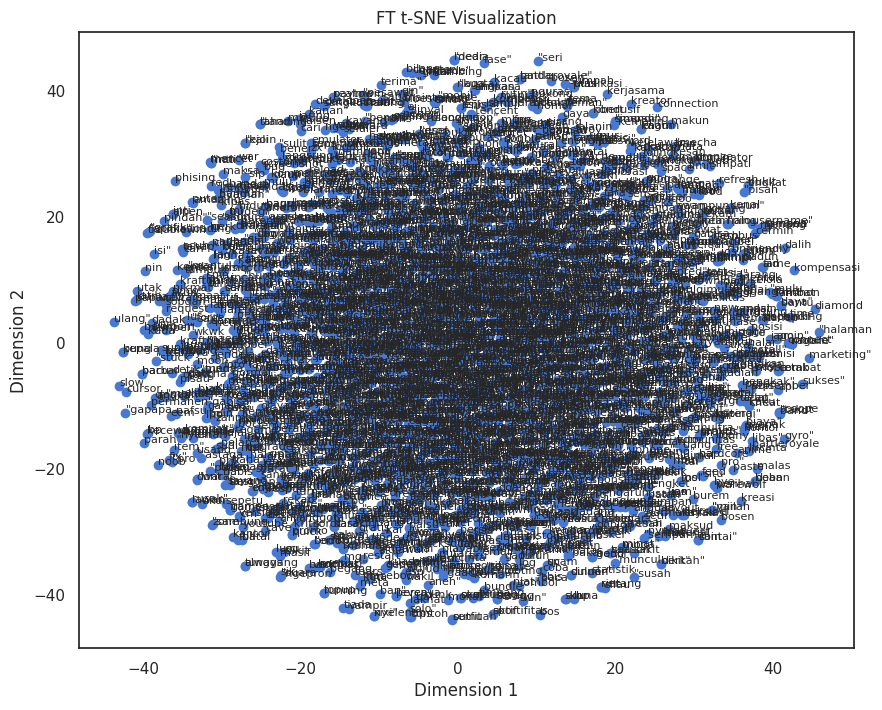

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(word_vector_2d_tsne[:, 0], word_vector_2d_tsne[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, (word_vector_2d_tsne[i, 0], word_vector_2d_tsne[i, 1]), fontsize=8)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('FT t-SNE Visualization')
plt.show()

FastText (tSNE) with KNN

In [38]:
n_neighbors = 1

nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(word_vector_2d_tsne)
distances, indices = nearest_neighbors.kneighbors(word_vector_2d_tsne)

subset_size = 100
words_subset = words[:subset_size]
word_vector_subset = word_vector_2d_tsne[:subset_size]

fig = px.scatter(x=word_vector_subset[:, 0], y=word_vector_subset[:, 1], title='Visualisasi Kata-kata Pada Ulasan (ft. Fasttext t-SNE)')

annotations = []
for i, word in enumerate(words_subset):
    annotations.append(
        dict(
            x=word_vector_subset[i, 0],
            y=word_vector_subset[i, 1],
            text=word,
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-30
        )
    )

lines = []
for i in range(subset_size):
    for neighbor_index in indices[i][1:]:
        lines.append(
            go.Scatter(
                x=[word_vector_subset[i, 0], word_vector_2d_tsne[neighbor_index, 0]],
                y=[word_vector_subset[i, 1], word_vector_2d_tsne[neighbor_index, 1]],
                mode="lines",
                line=dict(color="gray", width=1),
                showlegend=False
            )
        )

fig.update_layout(
    annotations=annotations,
    height=800,
    width=800,
    showlegend=False
)

for line in lines:
    fig.add_trace(line)

fig.show()

Check Similarity

In [39]:
model = fasttext.load_model('fasttext_model.bin')
word = 'terbaik'

neighbors = model.get_nearest_neighbors(word, k=5)

print(f"Kata yang mirip dengan '{word}':")
for neighbor in neighbors:
    print(neighbor)

Kata yang mirip dengan 'terbaik':
(0.0, 'frame')
(0.0, 'pubg')
(0.0, 'musuh')
(0.0, 'nyeleneh')
(0.0, 'cooldown')


# UMAP

In [40]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(response.toarray())

df['umap_1'] = X_umap[:, 0]
df['umap_2'] = X_umap[:, 1]

In [41]:
flg = px.scatter(df, x='umap_1', y='umap_2', color='Label', title='UMAP Visualization', text='textStemm')
flg.update_layout(height=650)
flg.show()

# Insight

## Word Cloud

Overall

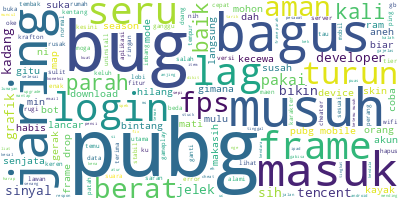

In [42]:
long_string = ','.join(list(df['textStemmSTR'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Positif (1), Negatif (0)



Label 0:


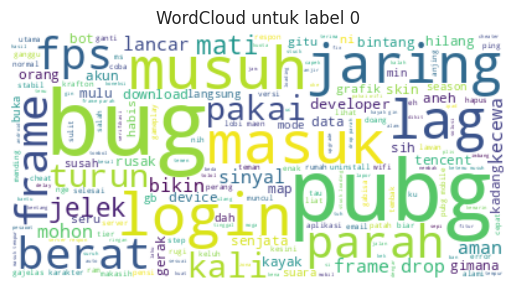


Label 1:


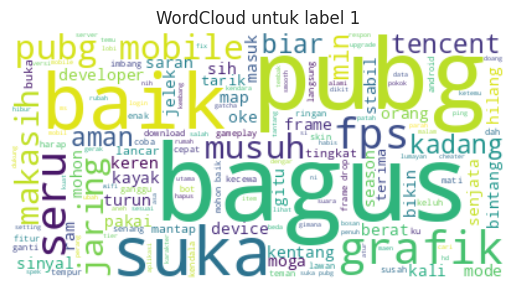

In [43]:
for label in df['Label'].unique():
    text_data = " ".join(df[df['Label'] == label]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nLabel {label}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk label {label}")
    plt.show()

## Top 10 Words

Overall

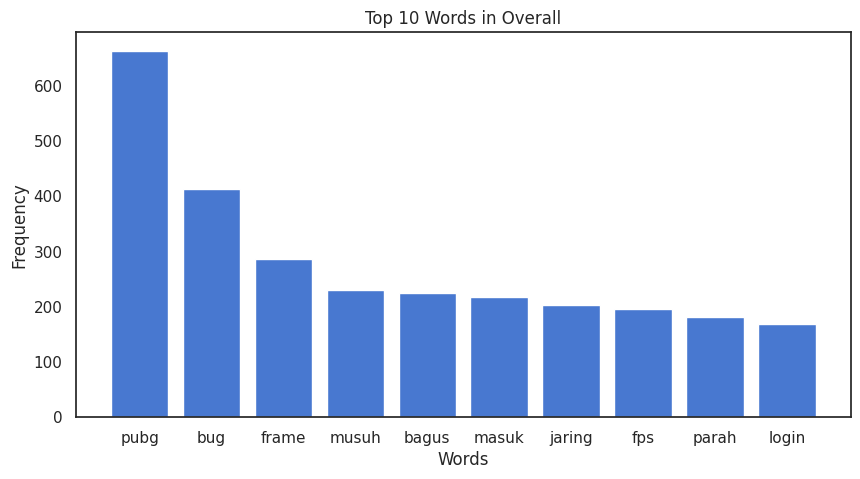

In [44]:
top_words = Counter(" ".join(df['textStemmSTR']).split()).most_common(10)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words in Overall')
plt.show()

Positif (1), Negatif (0)


label 0:


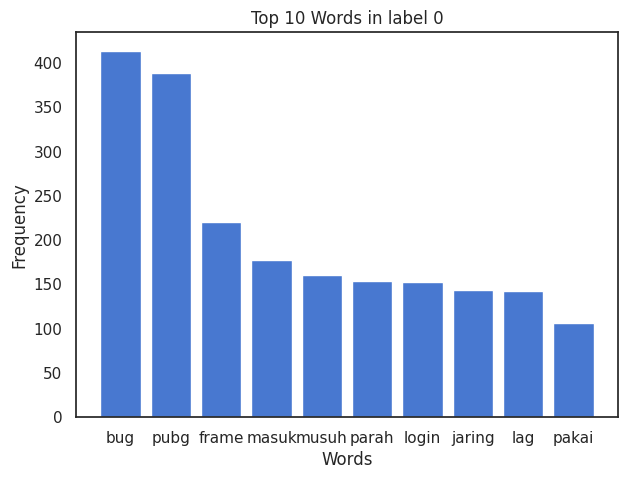


label 1:


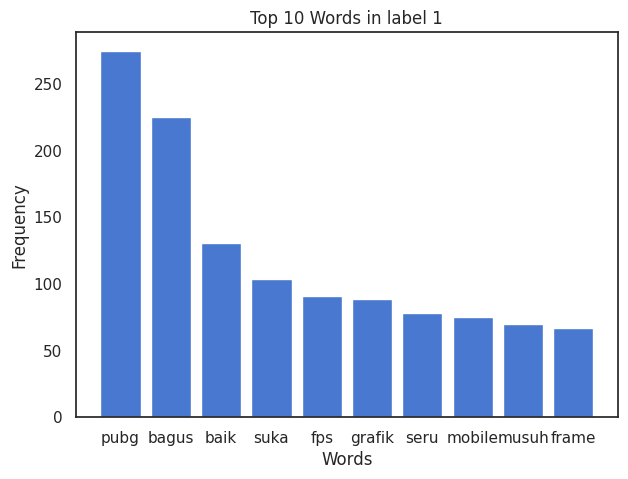

In [45]:
for label in df['Label'].unique():

    text_data = " ".join(df[df['Label'] == label]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nlabel {label}:")
    plt.figure(figsize=(7, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in label {label}')
    plt.show()

In [46]:
df['Label'] = df['Label'].replace({ 0 : 'Negatif', 1 : 'Positif'})

In [47]:
df.to_csv('RAW-Preprocessing-PUBGM.csv', index=False)

# Modelling: Clustering Label Negatif

In [48]:
df_neg = []

for index, row, in df.iterrows():
  if row['Label'] == 'Negatif':
    df_neg.append(row)

df_neg =  pd.DataFrame(df_neg)
df_neg = df_neg[:500]
df_neg.head()

content  score    Label  \
0  tolong dong kok kalau log in pakai jaringan wi...      2  Negatif   
1  pubg mobile sekarang sudah sepi masuk match ma...      2  Negatif   
2              server selalu bermasalah ketika login      1  Negatif   
3  game terlalu berat sering mati hp pas nembak m...      1  Negatif   
4  gyroscope pas arah ke bawa pelan malah naik se...      1  Negatif   

                                           textToken  \
0  [tolong, dong, kok, kalau, log, in, pakai, jar...   
1  [pubg, mobile, sekarang, sudah, sepi, masuk, m...   
2        [server, selalu, bermasalah, ketika, login]   
3  [game, terlalu, berat, sering, mati, hp, pas, ...   
4  [gyroscope, pas, arah, ke, bawa, pelan, malah,...   

                                           textLemma  \
0  [tolong, dong, kok, kalau, log, in, pakai, jar...   
1  [pubg, mobile, sekarang, sudah, sepi, masuk, m...   
2           [server, selalu, masalah, ketika, login]   
3  [game, terlalu, berat, sering, mati, hp, pas, ...   
4  [gyroscope, pas, arah, ke, bawa, pelan, malah,...   

                                             textSWR  \
0  [log, in, pakai, jaring, wifi, masuk, aplikasi...   
1  [pubg, mobile, sepi, masuk, match, making, nun...   
2                                    [server, login]   
3  [game, berat, mati, hp, pas, nembak, maaf, bin...   
4  [gyroscope, pas, arah, bawa, pelan, arah, pela...   

                                           textStemm  \
0  [log, pakai, jaring, wifi, masuk, aplikasi, la...   
1  [pubg, mobile, sepi, masuk, making, nunggu, me...   
2                                    [server, login]   
3       [berat, mati, nembak, maaf, bintang, kecewa]   
4  [gyroscope, arah, bawa, pelan, arah, pelan, tu...   

                                        textStemmSTR    umap_1     umap_2  
0        log pakai jaring wifi masuk aplikasi lancar  3.028123  15.560835  
1  pubg mobile sepi masuk making nunggu menit mas...  2.958176  14.952651  
2                                       server login  2.273083  15.666934  
3              berat mati nembak maaf bintang kecewa  5.024427  16.732328  
4  gyroscope arah bawa pelan arah pelan turun atu...  4.428319  18.107784

In [49]:
len(df_neg)

500

In [50]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=1500)

response = tfidf.fit_transform(df_neg['textStemmSTR'])

data_IDF_neg = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names_out())

## KMeans

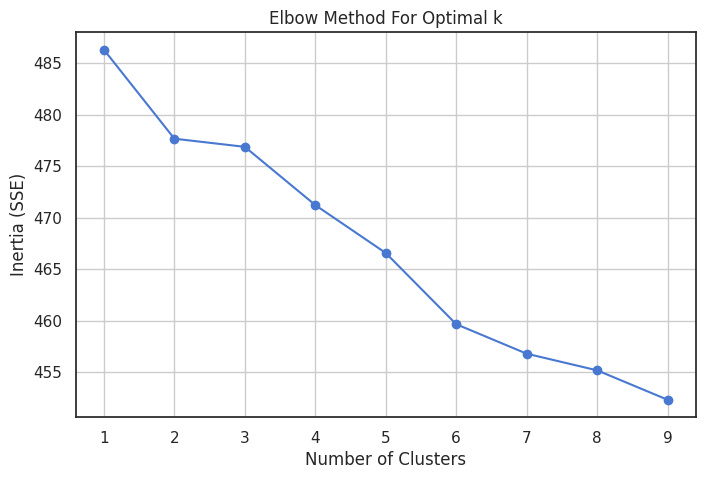

In [51]:
inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_IDF_neg)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [52]:
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_neg['Cluster_KMeans'] = kmeans.fit_predict(data_IDF_neg)

In [53]:
silhouette_avg = silhouette_score(data_IDF_neg, df_neg['Cluster_KMeans'])
print(f"The average silhouette_score is : {silhouette_avg}")

The average silhouette_score is : 0.017980491340067524



Cluster (KMeans) 4:


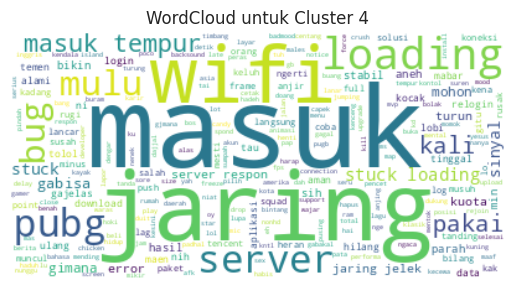


Cluster (KMeans) 0:


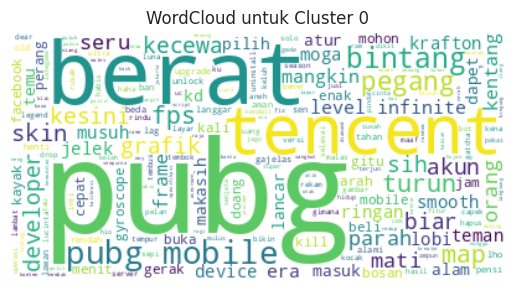


Cluster (KMeans) 3:


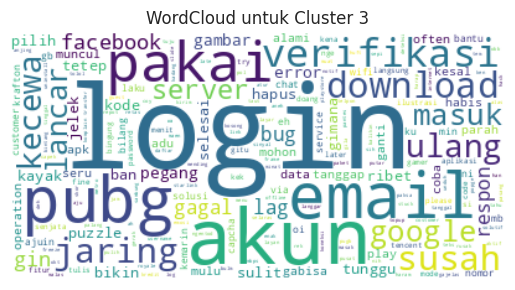


Cluster (KMeans) 5:


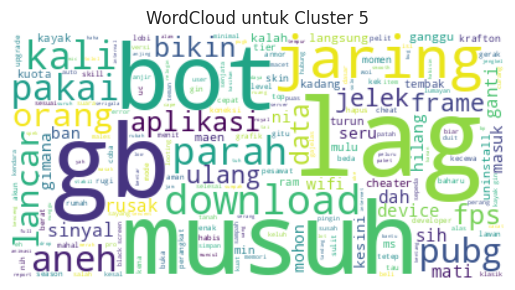


Cluster (KMeans) 2:


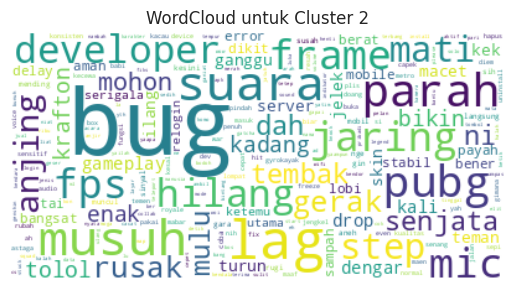


Cluster (KMeans) 1:


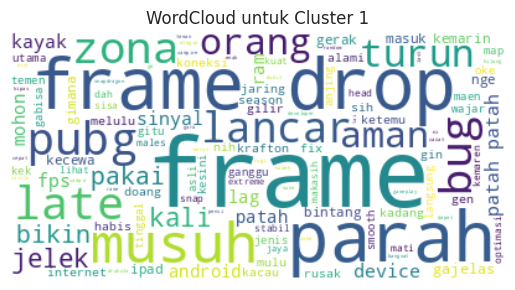

In [54]:
for cluster in df_neg['Cluster_KMeans'].unique():
    text_data = " ".join(df_neg[df_neg['Cluster_KMeans'] == cluster]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nCluster (KMeans) {cluster}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Cluster {cluster}")
    plt.show()


Cluster (KMeans) 4:


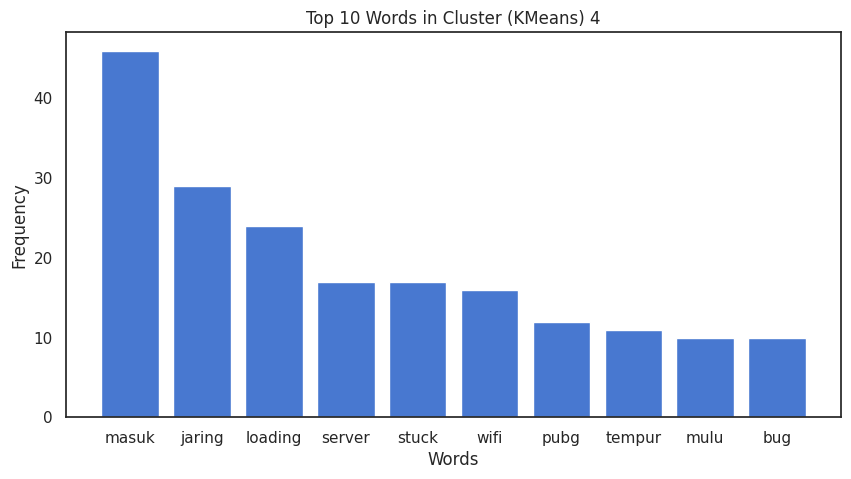


Cluster (KMeans) 0:


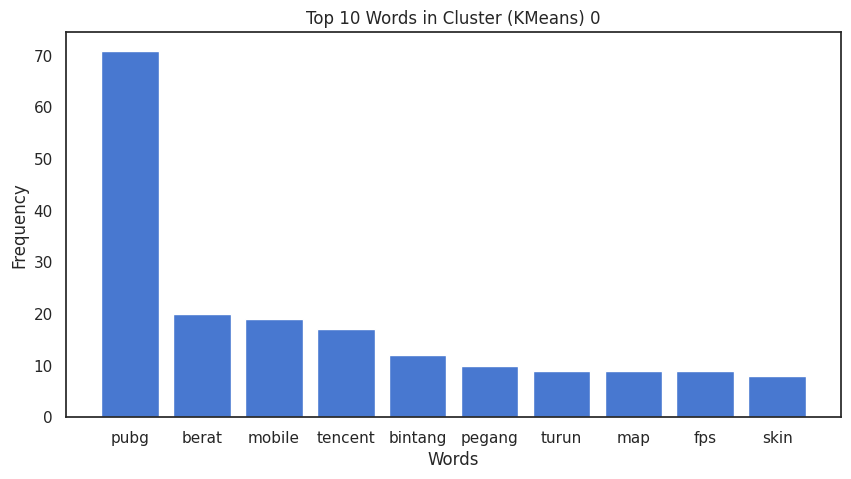


Cluster (KMeans) 3:


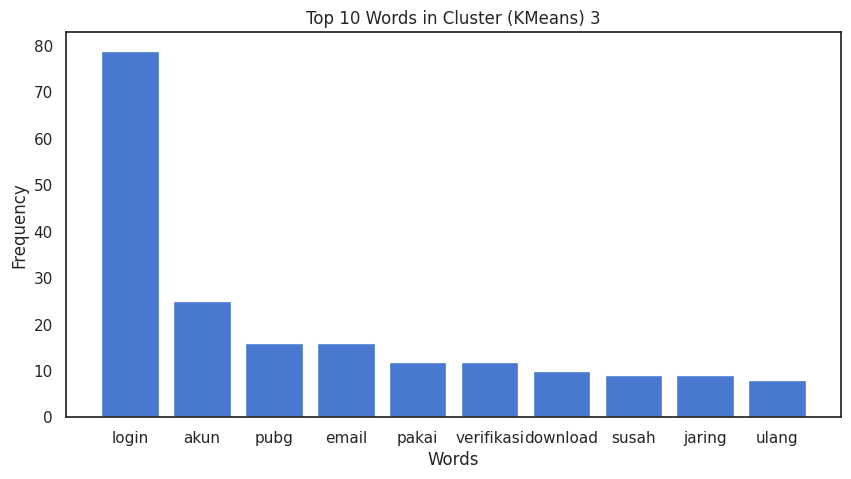


Cluster (KMeans) 5:


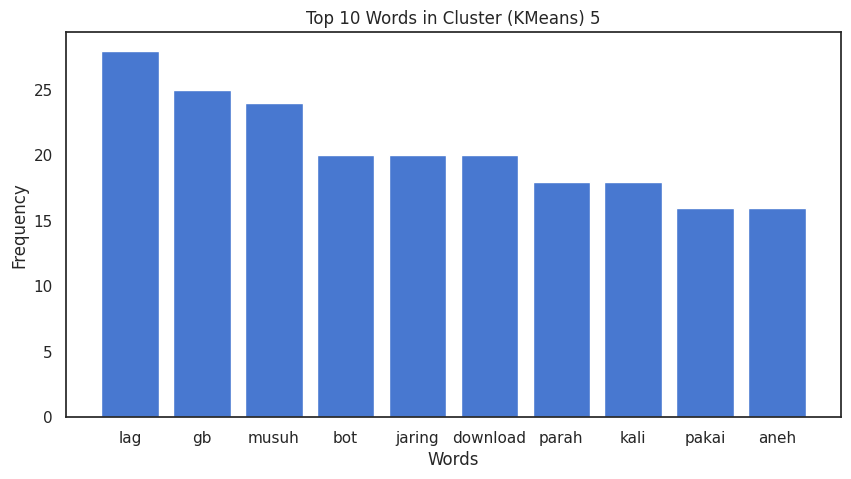


Cluster (KMeans) 2:


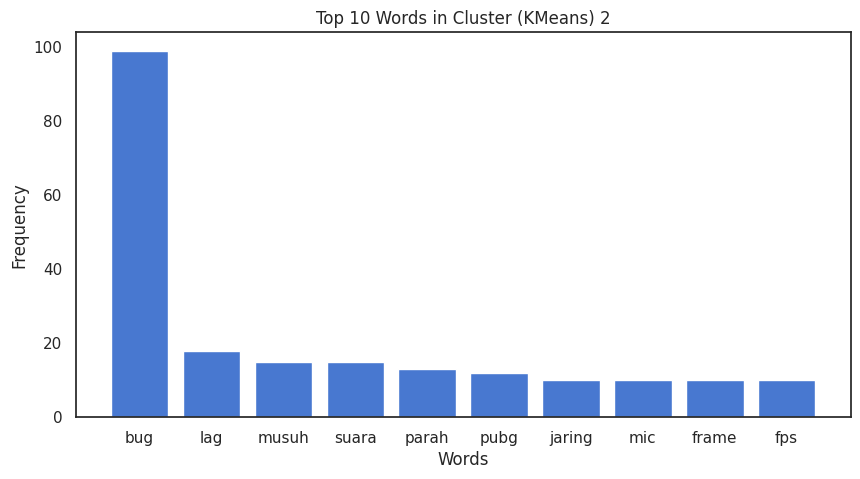


Cluster (KMeans) 1:


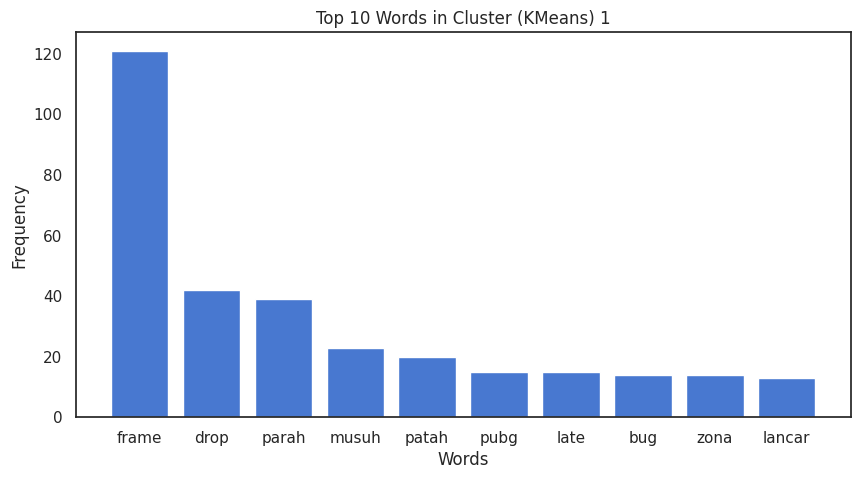

In [55]:
for cluster in df_neg['Cluster_KMeans'].unique():

    text_data = " ".join(df_neg[df_neg['Cluster_KMeans'] == cluster]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nCluster (KMeans) {cluster}:")
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in Cluster (KMeans) {cluster}')
    plt.show()

## Hierarchy

In [56]:
linkage_methods = ['single', 'complete', 'average', 'ward']

for method in linkage_methods:
  agg_clustering = AgglomerativeClustering(n_clusters=2, linkage=method, metric='euclidean')
  agg_clustering.fit(data_IDF_neg)

  print(f"Cluster Labels for {method} linkage:")
  labels = agg_clustering.labels_
  silhouette_avg = silhouette_score(data_IDF_neg, labels)
  print(f"For {method} linkage:")
  print(f"The average silhouette_score is : {silhouette_avg}")
  print("--------------------------------------------------------------------")

Cluster Labels for single linkage:
For single linkage:
The average silhouette_score is : 0.010549683834452104
--------------------------------------------------------------------
Cluster Labels for complete linkage:
For complete linkage:
The average silhouette_score is : 0.0026511453176742213
--------------------------------------------------------------------
Cluster Labels for average linkage:
For average linkage:
The average silhouette_score is : 0.01176619869022495
--------------------------------------------------------------------
Cluster Labels for ward linkage:
For ward linkage:
The average silhouette_score is : 0.002858818689674447
--------------------------------------------------------------------


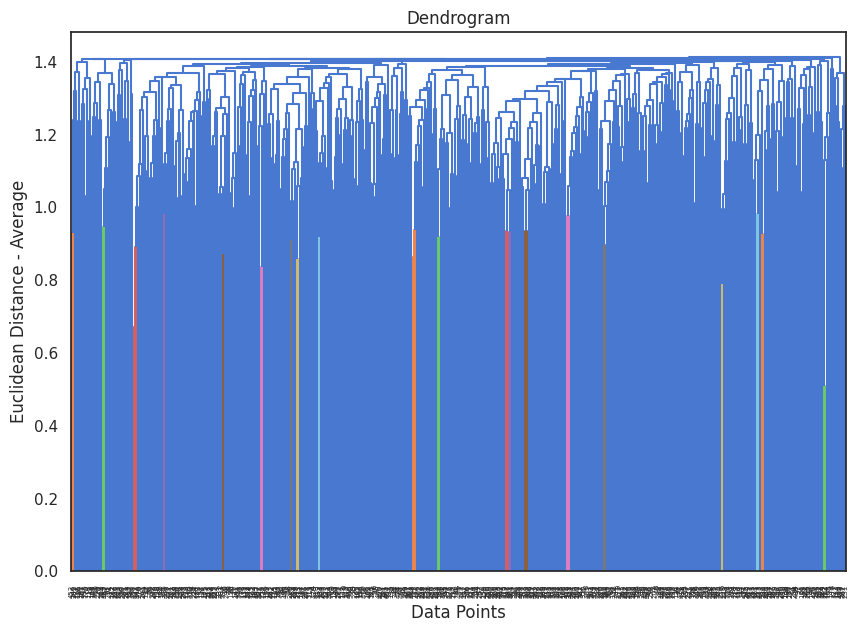

In [57]:
linked = linkage(data_IDF_neg, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance - Average')
plt.show()

In [58]:
num_clusters = 10

clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='average')
df_neg['Cluster_H_Average'] = clustering.fit_predict(data_IDF_neg)


Cluster (H_Average) 0:


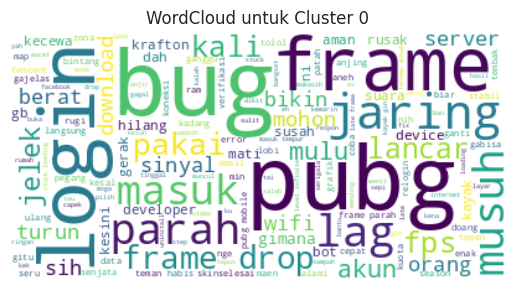


Cluster (H_Average) 6:


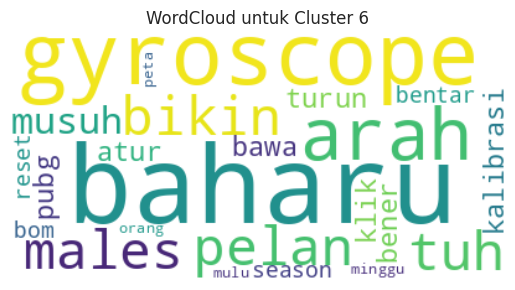


Cluster (H_Average) 4:


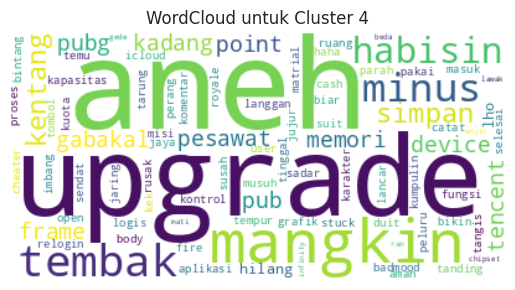


Cluster (H_Average) 5:


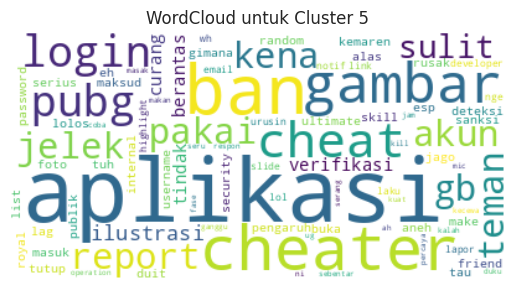


Cluster (H_Average) 9:


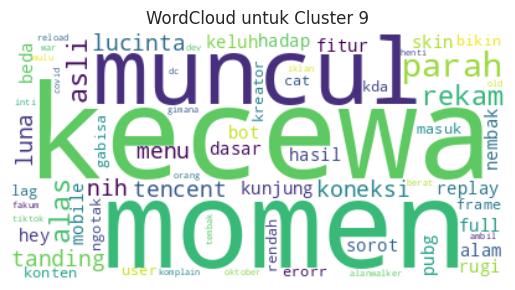


Cluster (H_Average) 3:


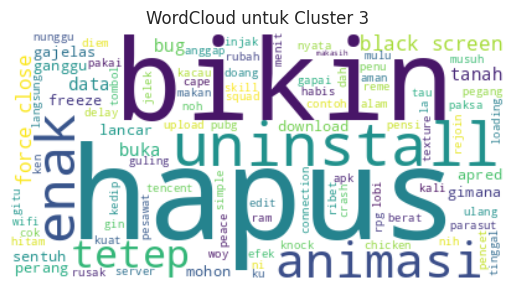


Cluster (H_Average) 1:


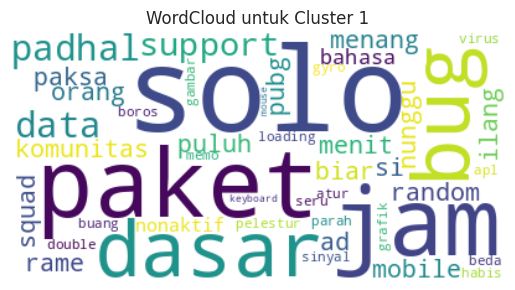


Cluster (H_Average) 7:


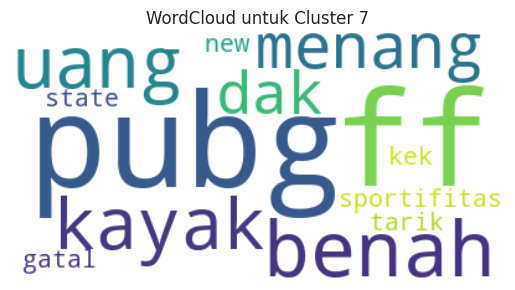


Cluster (H_Average) 2:


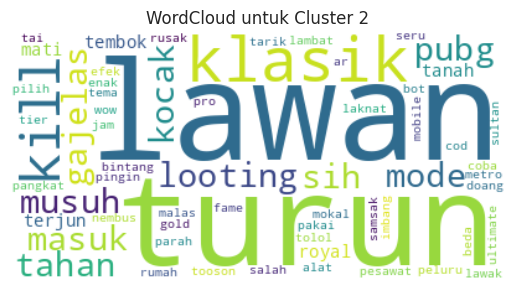


Cluster (H_Average) 8:


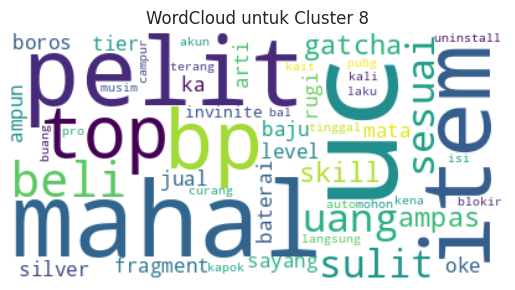

In [59]:
for cluster in df_neg['Cluster_H_Average'].unique():
    text_data = " ".join(df_neg[df_neg['Cluster_H_Average'] == cluster]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nCluster (H_Average) {cluster}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Cluster {cluster}")
    plt.show()


Cluster (H_Average) 0:


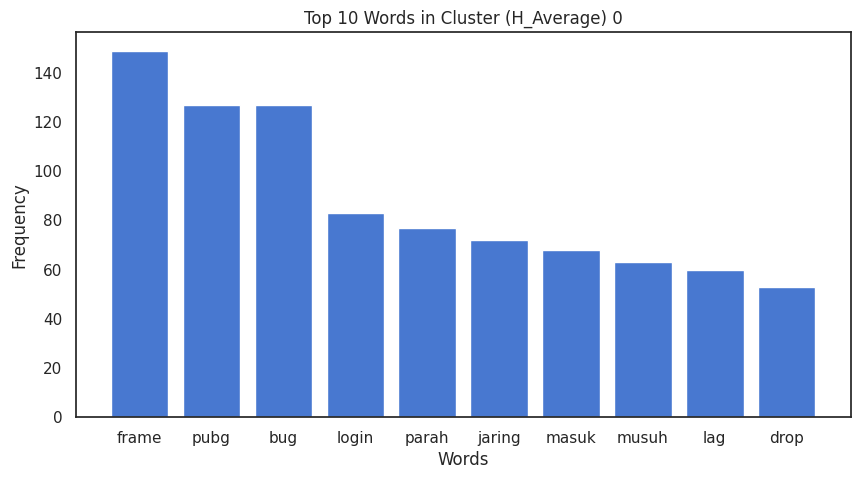


Cluster (H_Average) 6:


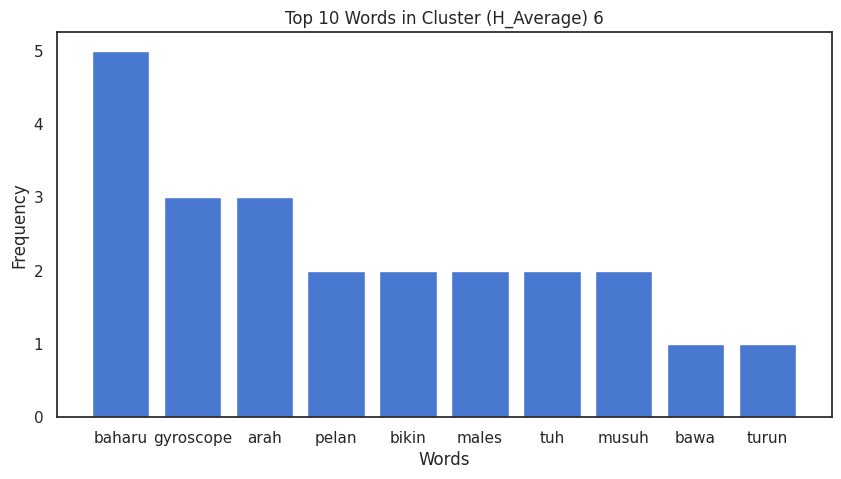


Cluster (H_Average) 4:


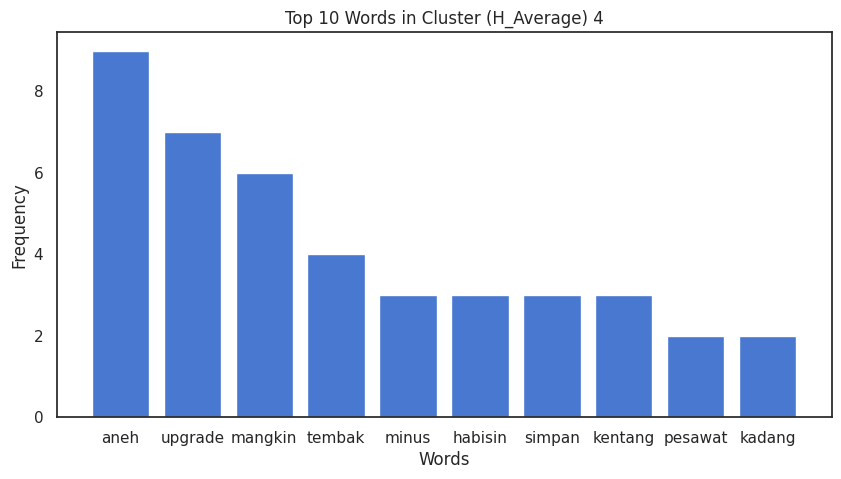


Cluster (H_Average) 5:


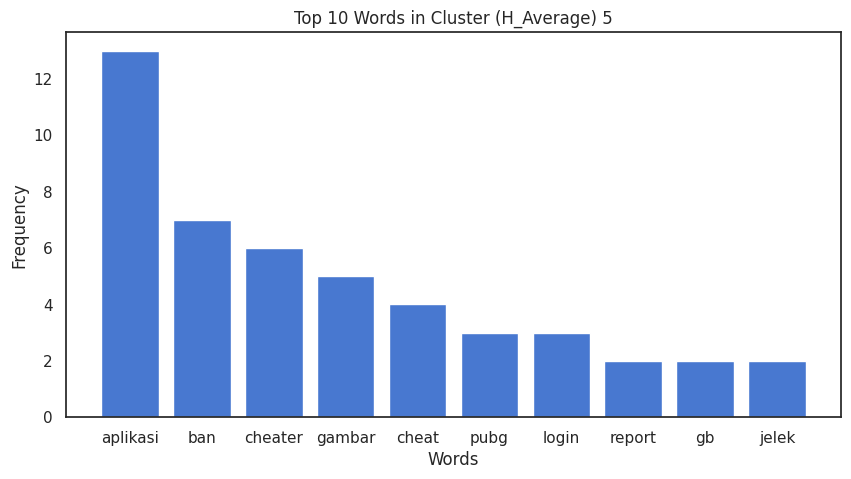


Cluster (H_Average) 9:


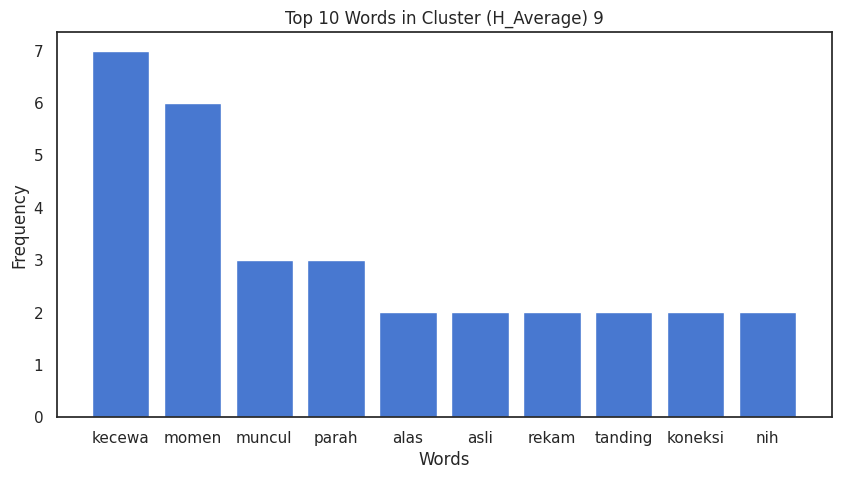


Cluster (H_Average) 3:


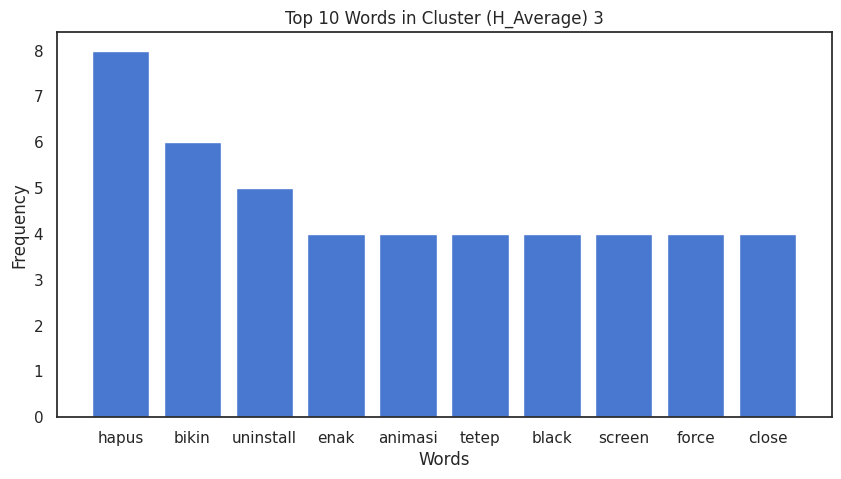


Cluster (H_Average) 1:


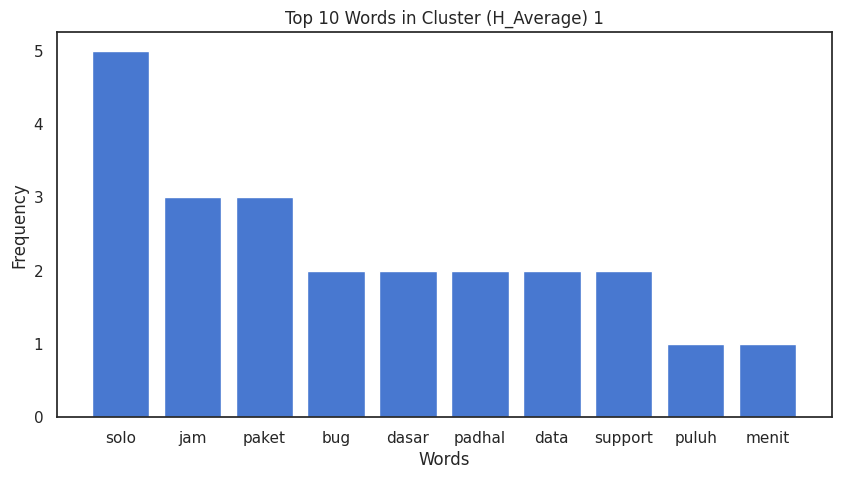


Cluster (H_Average) 7:


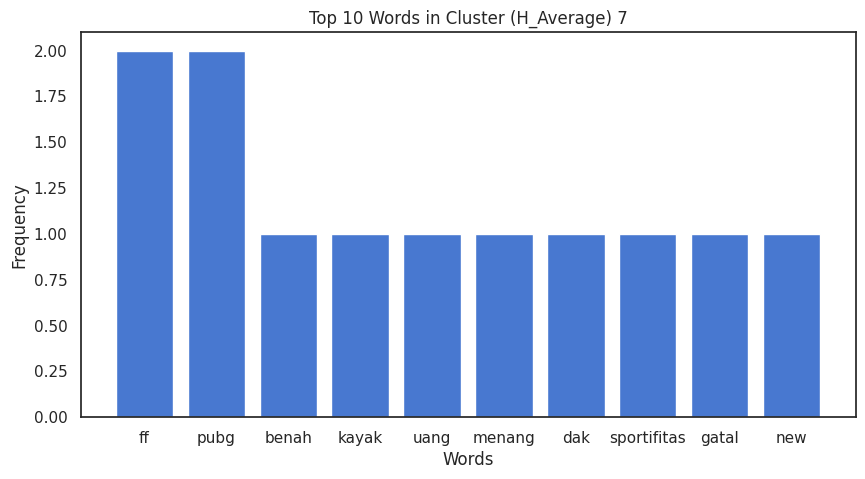


Cluster (H_Average) 2:


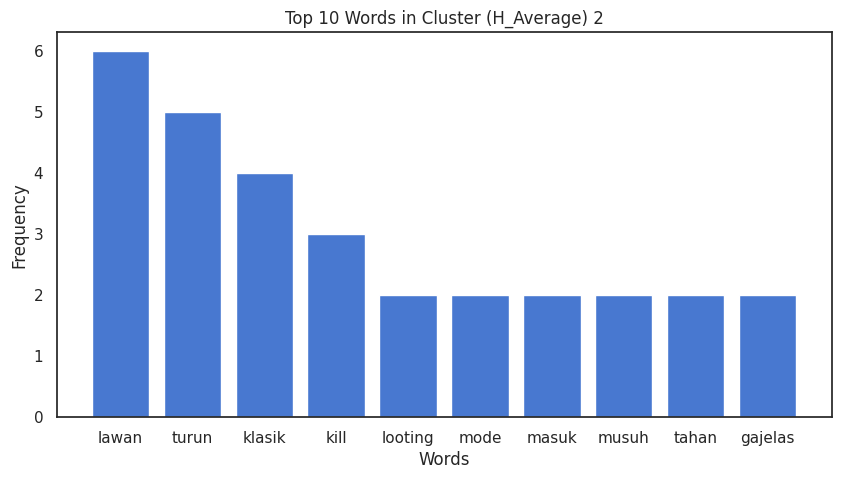


Cluster (H_Average) 8:


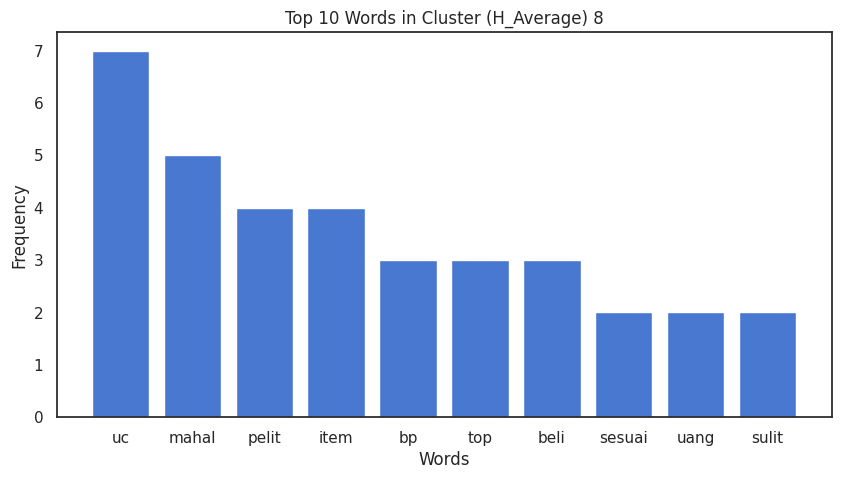

In [60]:
for cluster in df_neg['Cluster_H_Average'].unique():

    text_data = " ".join(df_neg[df_neg['Cluster_H_Average'] == cluster]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nCluster (H_Average) {cluster}:")
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in Cluster (H_Average) {cluster}')
    plt.show()

## Save to Csv

In [61]:
df_neg.to_csv('Hasil Clustering PUBGM.csv', index=False)